<a href="https://colab.research.google.com/github/Maggiey01/Rights-Colab-YH/blob/main/DEF14A_DEI_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial drive mount and imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import datetime
import numpy as np
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random

import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
import itertools
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Import files

Load original DEF14A files

In [ ]:
path = '/content/drive/My Drive/DFG/DEF_Indicator/'


In [ ]:
txt_path = '/content/drive/My Drive/DFG/DEF14A_Data'
DEF20_txtlist = []
for file in os.listdir(txt_path):  
  if (file[0:6]=='DEF20_') & (file[-3:] == 'csv'):
    DEF20_txtlist.append(file)
    print(file)

DEF20_1.csv
DEF20_2.csv
DEF20_3.csv
DEF20_4.csv
DEF20_5.csv
DEF20_6.csv


In [ ]:
for i in DEF20_txtlist:
  print(pd.read_csv(txt_path+'/'+i).shape)

(991, 6)
(1000, 6)
(1000, 6)
(1000, 6)
(1000, 6)
(371, 6)


In [ ]:
def drop_missing(df_input):
  #drop rows missing industry info 
  t1 = df_input[df_input['industry_id'].notna()]
  print(t1.shape)
  #drop rows missing body_text - float nan?
  t1 = t1.loc[[isinstance(val, str) for val in t1.body], :]
  print(t1.shape)
  # missing files index in DEF_df 
  miss_index = [item for item in list(df_input.index) if item not in list(t1.index)] 
  # calculate files missing industry info/body text
  miss_num = len(miss_index)
  print(f'{t1.shape[0]} files are valid')
  print(f"{miss_num} files' industry id are missing")
  #return t1, miss_index, miss_num
  return t1

In [ ]:
[drop_missing(pd.read_csv(txt_path+'/'+i)) for i in DEF20_txtlist]

(629, 6)
(628, 6)
628 files are valid
363 files' industry id are missing
(651, 6)
(649, 6)
649 files are valid
351 files' industry id are missing
(646, 6)
(646, 6)
646 files are valid
354 files' industry id are missing
(613, 6)
(613, 6)
613 files are valid
387 files' industry id are missing
(692, 6)
(692, 6)
692 files are valid
308 files' industry id are missing
(248, 6)
(248, 6)
248 files are valid
123 files' industry id are missing


In [ ]:
363,351,354,387,308,123

In [ ]:
import pandas as pd
import seaborn as sns
amount_pd = pd.DataFrame({'total files':[991,1000,1000,1000,1000,371],'valid files':[628,649,646,613,692,248],'missing files':[363,351,354,387,308,123]})


In [ ]:
amount_pd['missing files'].sum()

1886

overall 5362 files in 2020, valid files 3476, 1886 are missing

# Count segmented paragraph txt csv 
36 overall

Load Indicator files

In [ ]:
import os
Indi_path = '/content/drive/My Drive/DFG/DEF_Indicator'
import re
DEF20_list = []
for file in os.listdir(Indi_path):  
  if (file[0:6]=='DEF20_') & (file[-3:] == 'csv'):
    DEF20_list.append(file)
    print(file)

DEF20_1df_para_1000_2000.csv
DEF20_1df_para_200.csv
DEF20_1df_para_400.csv
DEF20_1df_para_600.csv
DEF20_1df_para_600_1000.csv


# Load segmented paragraph txt csv
total 196973 paragraph in 36 indicators csv, from 3138 valid files in 2018

In [ ]:
path = '/content/drive/My Drive/DFG/DEF_Indicator/'
total_para = 0
for i in DEF20_list:
  DEF18_read_i = pd.read_csv(path+'/'+i) 
  total_para = total_para+DEF18_read_i.shape[0]
  print(DEF18_read_i.shape)
  print(total_para)

(5944, 109)
5944
(6977, 109)
12921
(6166, 109)
19087
(6455, 109)
25542
(5835, 109)
31377
(6464, 109)
37841
(4844, 109)
42685
(6407, 109)
49092
(7149, 109)
56241
(6188, 109)
62429
(6985, 109)
69414
(6029, 109)
75443
(3330, 109)
78773
(6289, 109)
85062
(5926, 109)
90988
(8015, 109)
99003
(7002, 109)
106005
(6534, 109)
112539
(7467, 109)
120006
(3848, 109)
123854
(6528, 109)
130382
(5812, 109)
136194
(6861, 109)
143055
(5362, 109)
148417
(3041, 109)
151458
(3188, 109)
154646
(2943, 109)
157589
(2517, 109)
160106
(3046, 109)
163152
(6810, 109)
169962
(6397, 109)
176359
(3134, 109)
179493
(3168, 109)
182661
(5946, 109)
188607
(6749, 109)
195356
(1617, 109)
196973


## Step1: OUTCOME_TERMS_FOUND 
TAR indicator = 1
overall 1238 hits in all paragraphs

In [ ]:
df_tar = pd.DataFrame()
count_TAR=[]
path = '/content/drive/My Drive/DFG/DEF_Indicator/'
for i, dfi in enumerate(DEF20_list):
  
  DEF20_read_i = pd.read_csv(path+'/'+dfi) 
  
  #how many TAR indicator in each paragraph csv
  #print(DEF18_read_i.loc[DEF18_read_i['TAR_ind']==1,:].shape[0])
  #count_TAR.append(DEF18_read_i.loc[DEF18_read_i['TAR_ind']==1,:].shape[0])
  #print(dfi)
  #df_tar = df_tar.append(DEF18_read_i.loc[DEF18_read_i['TAR_ind']==1,:])
  df_tar = df_tar.append(DEF20_read_i)
  #overall all TAR indicator hits in all files
  print(df_tar.shape[0])
  print(dfi)

0
DEF20_1df_para_1000_2000.csv
200
DEF20_1df_para_200.csv
200
DEF20_1df_para_400.csv
200
DEF20_1df_para_600.csv
200
DEF20_1df_para_600_1000.csv


have processed: 902 tickers' DEF14A in 2018

In [ ]:
print(f"{len(list(df_tar.groupby('label')['label'].count()))} tickers' 2020 DEF14A are hit by TAR_indicator ")

902 tickers' 2018 DEF14A are hit by TAR_indicator 


In [ ]:
df_tar.shape

(1238, 109)

# Group by ticker

In [ ]:
df_tar.describe()

,Unnamed: 0,index,PRACTICE_TERMS_FOUND,PDMD_TERMS_FOUND,CR_TERMS_FOUND,IRR_TERMS_FOUND,TAR_ind,PDMD_ind,CR_ind,IRR_ind,...,race _DEI-CONTEXT_race,latino_DEI-CONTEXT_race,factory work_DEI-CONTEXT_factory work,youth_DEI-CONTEXT_youth,minorities_DEI-CONTEXT_minorit,age bias_DEI-CONTEXT_age,gender_DEI-CONTEXT_gender-M/F,working (famil|parent|mother|mom|father|dad)_DEI-CONTEXT_familial status,religio_DEI-CONTEXT_religio,high(-| )income_DEI-CONTEXT_economic status
count,1238.000000,1238.000000,0.0,0.0,0.0,0.0,1238.0,1238.0,1238.0,1238.0,...,1238.000000,1238.0,1238.0,1238.0,1238.000000,1238.0,1238.000000,1238.0,1238.0,1238.0
mean,46.779483,18.072698,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,...,0.008078,0.0,0.0,0.0,0.001616,0.0,0.050081,0.0,0.0,0.0
std,62.372099,22.585031,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.089548,0.0,0.0,0.0,0.040177,0.0,0.218200,0.0,0.0,0.0
min,0.000000,0.000000,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
25%,11.000000,3.000000,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
50%,17.000000,15.000000,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
75%,55.000000,24.000000,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
max,463.000000,170.000000,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import csv
df_tar.to_csv('/content/drive/My Drive/DFG/df_tar_2018.csv')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_tar.columns

Index(['Unnamed: 0', 'para_index', 'label', 'industry_id', 'index',
       'OUTCOME_TERMS_FOUND', 'PRACTICE_TERMS_FOUND',
       'DEI-CONTEXT_TERMS_FOUND', 'TAR_TERMS_FOUND', 'PDMD_TERMS_FOUND',
       ...
       ' race _DEI-CONTEXT_race', 'latino_DEI-CONTEXT_race',
       'factory work_DEI-CONTEXT_factory work', 'youth_DEI-CONTEXT_youth',
       'minorities_DEI-CONTEXT_minorit', 'age bias_DEI-CONTEXT_age',
       'gender_DEI-CONTEXT_gender-M/F',
       'working (famil|parent|mother|mom|father|dad)_DEI-CONTEXT_familial status',
       'religio_DEI-CONTEXT_religio',
       'high(-| )income_DEI-CONTEXT_economic status'],
      dtype='object', length=109)

In [ ]:
df_tar_label = df_tar.groupby('label').count()

In [ ]:
df_tar_label.head()

,Unnamed: 0,para_index,industry_id,index,OUTCOME_TERMS_FOUND,PRACTICE_TERMS_FOUND,DEI-CONTEXT_TERMS_FOUND,TAR_TERMS_FOUND,PDMD_TERMS_FOUND,CR_TERMS_FOUND,...,race _DEI-CONTEXT_race,latino_DEI-CONTEXT_race,factory work_DEI-CONTEXT_factory work,youth_DEI-CONTEXT_youth,minorities_DEI-CONTEXT_minorit,age bias_DEI-CONTEXT_age,gender_DEI-CONTEXT_gender-M/F,working (famil|parent|mother|mom|father|dad)_DEI-CONTEXT_familial status,religio_DEI-CONTEXT_religio,high(-| )income_DEI-CONTEXT_economic status
label,,,,,,,,,,,,,,,,,,,,,
AA_DEF 14A_0001193125-18-089163,1,1,1,1,1,0,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
ABUS_DEF 14A_0001628280-18-004972,1,1,1,1,1,0,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
ACCO_DEF 14A_0001140361-18-015019,1,1,1,1,1,0,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
ACGL_DEF 14A_0000947484-18-000030,1,1,1,1,1,0,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
ADT_DEF 14A_0001193125-18-244339,1,1,1,1,1,0,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
df_tar_label["rank_outcome"] = df_tar_label["OUTCOME_TERMS_FOUND"].rank(method='max',ascending=False)
df_tar_label["rank_practice"] = df_tar_label["PRACTICE_TERMS_FOUND"].rank(method='max',ascending=False)

In [ ]:
df_tar_label['PRACTICE_TERMS_FOUND'].unique()

array([0])

## Outcome terms found hit in each label file

In [ ]:
#rank by outcome terms found hit in each label
df_tar_label.sort_values('rank_outcome')[['OUTCOME_TERMS_FOUND','PRACTICE_TERMS_FOUND']]

,OUTCOME_TERMS_FOUND,PRACTICE_TERMS_FOUND
label,,
XRAY_DEF 14A_0001193125-18-111555,6,0
WEN_DEF 14A_0001193125-18-125056,6,0
WMB_DEF 14A_0001193125-18-113608,5,0
KOP_DEF 14A_0001193125-18-102060,4,0
KALU_DEF 14A_0000811596-18-000024,4,0
...,...,...
FUN_DEF 14A_0001193125-18-133267,1,0
HMN_DEF 14A_0001193125-18-109608,1,0
HMTV_DEF 14A_0001047469-18-002751,1,0


In [ ]:
import seaborn as sns
df_tar_label.sort_values('rank_outcome')[['OUTCOME_TERMS_FOUND','PRACTICE_TERMS_FOUND']].groupby('OUTCOME_TERMS_FOUND').count()

,PRACTICE_TERMS_FOUND
OUTCOME_TERMS_FOUND,
1,638
2,207
3,47
4,7
5,1
6,2


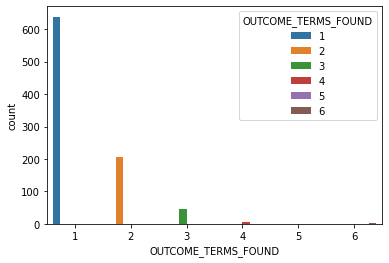

In [ ]:
sns.countplot(x="OUTCOME_TERMS_FOUND",
           hue="OUTCOME_TERMS_FOUND",
           data=df_tar_label)

In [ ]:
df_tar.OUTCOME_TERMS_FOUND.unique()
#what outcome terms found in each file

array(["workforce composition (Talent-Attraction-Retention): [('composition', 'director(s)', ' access'), [7, 25]]\n[('composition', 'manage(ment|r(s)?)', ' access'), [7, 25]]\n\n",
       "workforce composition (Talent-Attraction-Retention): [(' only', 'director(s)', 'black'), [7, 25]]\n\n",
       "aging workforce (Talent-Attraction-Retention): [(' old(er)?', 'employee(s)?', ' old(er)?'), [7, 25]]\n[(' old(er)?', 'employee(s)?', ' old(er)?'), [7, 25]]\n[(' old(er)?', 'employee(s)?', ' old(er)?'), [7, 25]]\n[(' old(er)?', 'employee(s)?', ' old(er)?'), [7, 25]]\n\n",
       "workforce composition (Talent-Attraction-Retention): [(' only', 'director(s)', 'young'), [7, 25]]\n\n",
       "talent attraction (Talent-Attraction-Retention): [('attract(s|ed|ion)?', 'skill(s|ed)?', '(low|un|semi|high)(-|ly | |)skill'), [7, 25]]\n\ntalent retention (Talent-Attraction-Retention): [('retain(ed)?', 'skill(s|ed)?', '(low|un|semi|high)(-|ly | |)skill'), [7, 25]]\n\n",
       "talent retention (Talent-A

In [ ]:
df_tar.OUTCOME_TERMS_FOUND.unique()

In [ ]:
df_tar.groupby('OUTCOME_TERMS_FOUND', as_index=False)['label'].count()

,OUTCOME_TERMS_FOUND,label
0,aging workforce (Talent-Attraction-Retention):...,201
1,aging workforce (Talent-Attraction-Retention):...,2
2,aging workforce (Talent-Attraction-Retention):...,36
3,aging workforce (Talent-Attraction-Retention):...,89
4,aging workforce (Talent-Attraction-Retention):...,8
5,discrimination lawsuit (Talent-Attraction-Rete...,1
6,talent attraction (Talent-Attraction-Retention...,167
7,talent attraction (Talent-Attraction-Retention...,13
8,talent attraction (Talent-Attraction-Retention...,2
9,talent attraction (Talent-Attraction-Retention...,3


## Practice terms found hit in each label file
all 0

In [ ]:
df_tar_label.sort_values('rank_practice')[['OUTCOME_TERMS_FOUND','PRACTICE_TERMS_FOUND']].groupby('PRACTICE_TERMS_FOUND').count()

,OUTCOME_TERMS_FOUND
PRACTICE_TERMS_FOUND,
0,902


## Group by industry

In [ ]:
df_tar.groupby('industry_id').count().sort_values('OUTCOME_TERMS_FOUND', ascending = False)

,Unnamed: 0,para_index,label,index,OUTCOME_TERMS_FOUND,PRACTICE_TERMS_FOUND,DEI-CONTEXT_TERMS_FOUND,TAR_TERMS_FOUND,PDMD_TERMS_FOUND,CR_TERMS_FOUND,...,race _DEI-CONTEXT_race,latino_DEI-CONTEXT_race,factory work_DEI-CONTEXT_factory work,youth_DEI-CONTEXT_youth,minorities_DEI-CONTEXT_minorit,age bias_DEI-CONTEXT_age,gender_DEI-CONTEXT_gender-M/F,working (famil|parent|mother|mom|father|dad)_DEI-CONTEXT_familial status,religio_DEI-CONTEXT_religio,high(-| )income_DEI-CONTEXT_economic status
industry_id,,,,,,,,,,,,,,,,,,,,,
FN-CB,103,103,103,103,103,0,103,103,0,0,...,103,103,103,103,103,103,103,103,103,103
HC-BP,95,95,95,95,95,0,95,95,0,0,...,95,95,95,95,95,95,95,95,95,95
IF-RE,83,83,83,83,83,0,83,83,0,0,...,83,83,83,83,83,83,83,83,83,83
RT-IG,65,65,65,65,65,0,65,65,0,0,...,65,65,65,65,65,65,65,65,65,65
HC-MS,63,63,63,63,63,0,63,63,0,0,...,63,63,63,63,63,63,63,63,63,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RR-ST,2,2,2,2,2,0,2,2,0,0,...,2,2,2,2,2,2,2,2,2,2
RR-FM,2,2,2,2,2,0,2,2,0,0,...,2,2,2,2,2,2,2,2,2,2
RR-PP,1,1,1,1,1,0,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
